In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


```
As explained in the pdf, for this model we would like to classify regions 0,
5-6. To do so, we must make a dummy category, 7, that will blind regions 1-4 and 7-8. 

Since the label encoder needs consequetive categories, we will shift the non zero labels by 4. Showing the new maping values as:

Original Category  --->    New Category
      0            --->         0
    1-4            --->         3
      5            --->         1
      6            --->         2
    7-8            --->         3

(Remeber '3' this a dummy category). This will be discarded when we merge
                                    the output mask of all models. Into an NxNx9.
```

In [5]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import nibabel as nb
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm 
from sys import getsizeof
from tensorflow.keras.models import load_model

import nibabel as nib

In [6]:
model

NameError: ignored

In [7]:
tf.keras.backend.clear_session()
del model

NameError: ignored

In [ ]:
512/4

128.0

In [8]:
# Define constants

# Path variables
data_dir = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/'
data_dir_train_image = os.path.join(data_dir, 'complete_dataset/training/img:-1000:1000/img/')
data_dir_train_mask = os.path.join(data_dir,  'complete_dataset/training/couinaud/img/')

data_dir_test_image = os.path.join(data_dir, 'complete_dataset/testing/img:-1000:1000/img/')
data_dir_test_mask = os.path.join(data_dir, 'complete_dataset/testing/couinaud/img/')

data_dir_validate_image = os.path.join(data_dir, 'complete_dataset/validate/img:-1000:1000/img/')
data_dir_validate_mask = os.path.join(data_dir, 'complete_dataset/validate/couinaud/img/')

class_names = ['class_0','class_1','class_2','class_3',
               'class_4','class_5','class_6','class_7','class_8']

# Training variables
SEED = 7
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_TEST = 10
BATCH_SIZE_VALIDATE = 10
NUM_TRAIN = 9288
NUM_TEST = 1042
NUM_VALIDATE = 1207

N_CLASSES = 4


# Image variables
IMAGE_HEIGHT = int(512/4)
IMAGE_WIDTH = int(512/4)
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


#Original Image size
OG_IMAGE_HEIGHT = 512
OG_IMAGE_WIDTH = 512
OG_IMG_SIZE = (OG_IMAGE_HEIGHT, OG_IMAGE_WIDTH)

NUM_EPOCH = 100


In [14]:
### Import the 'data' and save them in lists 

#Capture training image info as a list
#train_images = []
scaled_train_images = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_train_image+ '*.png')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #train_images.append(img)
  scaled_train_images.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing        
#train_images = np.array(train_images)
scaled_train_images = np.array(scaled_train_images)

print('##### TRAINING IMAGES #####')
#print(train_images.shape)
print(scaled_train_images.shape)
#print(type(train_images[0,0,0]))
##############################################################

#Capture mask/label info as a list
#train_masks = [] 
scaled_train_masks = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_train_mask + '*.tif')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #train_masks.append(img)
  other_mask_indices = (img != 0) & (img != 5) & (img != 6)
  img[other_mask_indices] = 7
  indices_all_but_0val = img > 0
  img[indices_all_but_0val] = img[indices_all_but_0val] - 4
  scaled_train_masks.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
#train_masks = np.array(train_masks)
scaled_train_masks = np.array(scaled_train_masks)

print('##### TRAINING MASKS #####') 
#print(train_masks.shape)
print(scaled_train_masks.shape)
#print(type(train_masks[0,0,0]))
##############################################################
##############################################################

#Capture validate image info as a list
#validate_images = []
scaled_validate_images = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_validate_image+ '*.png')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #validate_images.append(img)
  scaled_validate_images.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing        
#validate_images = np.array(validate_images)
scaled_validate_images = np.array(scaled_validate_images)

print('##### VALIDATE IMAGES #####')
#print(validate_images.shape)
print(scaled_validate_images.shape)
#print(type(validate_images[0,0,0]))
##############################################################

#Capture mask/label info as a list
#validate_masks = [] 
scaled_validate_masks = []

for index, img_path in tqdm(enumerate(sorted(glob.iglob(data_dir_validate_mask + '*.tif')))):
  substring = img_path[-5:]

  img = cv2.imread(img_path, 0)       
  #validate_masks.append(img)
  other_mask_indices = (img != 0) & (img != 5) & (img != 6)
  img[other_mask_indices] = 7
  indices_all_but_0val = img > 0
  img[indices_all_but_0val] = img[indices_all_but_0val] - 4
  scaled_validate_masks.append(cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_LINEAR))

#Convert list to array for machine learning processing      
#validate_masks = np.array(validate_masks)
scaled_validate_masks = np.array(scaled_validate_masks)

print('##### VALIDATE MASKS #####') 
#print(validate_masks.shape)
print(scaled_validate_masks.shape)
#print(type(validate_masks[0,0,0]))
##############################################################


##### TRAINING IMAGES #####
(9288, 128, 128)



##### TRAINING MASKS #####
(9288, 128, 128)



##### VALIDATE IMAGES #####
(1207, 128, 128)



##### VALIDATE MASKS #####
(1207, 128, 128)


In [15]:
from sklearn.utils import shuffle
scaled_train_images, scaled_train_masks = shuffle(scaled_train_images,scaled_train_masks, random_state = SEED)

In [16]:
scaled_train_images.shape

(9288, 128, 128)

In [17]:

round(getsizeof(scaled_train_images) / 1024 / 1024 / 1024 ,2) #to get GB 

0.14

In [ ]:
# np.unique(train_masks)

In [18]:
scaled_train_images = np.expand_dims(scaled_train_images, axis=3)
scaled_validate_images = np.expand_dims(scaled_validate_images, axis=3)


print('#### IMAGES ###')
# print(train_images.shape)
print(scaled_train_images.shape)
print(type(scaled_train_images[0,0,0,0]))

#print(validate_images.shape)
print(scaled_validate_images.shape)
print(type(scaled_validate_images[0,0,0,0]))

##########################################################################
scaled_train_masks = np.expand_dims(scaled_train_masks, axis=3)
scaled_validate_masks = np.expand_dims(scaled_validate_masks, axis=3)

print('#### MASKS ###')
#print(train_masks.shape)
print(scaled_train_masks.shape)

#print(validate_masks.shape)
print(scaled_validate_masks.shape)

#### IMAGES ###
(9288, 128, 128, 1)
<class 'numpy.uint8'>
(1207, 128, 128, 1)
<class 'numpy.uint8'>
#### MASKS ###
(9288, 128, 128, 1)
(1207, 128, 128, 1)


In [19]:
#Encode labels for all masks
scaled_train_masks = to_categorical(scaled_train_masks, num_classes=N_CLASSES)
#print(train_masks.shape)
print(scaled_train_masks.shape)

(9288, 128, 128, 4)


In [20]:
round(getsizeof(scaled_train_images) / 1024 / 1024 / 1024 ,2) #to get GB 

0.0

In [21]:
scaled_validate_masks = to_categorical(scaled_validate_masks, num_classes=N_CLASSES)
#print(validate_masks.shape)
print(scaled_validate_masks.shape)


(1207, 128, 128, 4)


In [22]:
def display(display_list):
  plt.figure(figsize = (15,15))
  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Predicted Mask \nw/ Threshold']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'Greys_r')
  plt.show()

In [23]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [24]:
checkpoint_filepath = '/content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/4-Models:0-2,3-4,5-6,7-8/Model3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [25]:
# Batches per epoch
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST
EPOCH_STEP_VALIDATE = NUM_VALIDATE // BATCH_SIZE_VALIDATE

model = unet(n_levels= 4, out_channels=4)
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [dice_coef])
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [soft_dice_loss])

In [26]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [27]:
history = model.fit(scaled_train_images, scaled_train_masks, 
                    batch_size = BATCH_SIZE_TRAIN, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    validation_data=(scaled_validate_images, scaled_validate_masks), 
                    validation_steps=EPOCH_STEP_VALIDATE,
                    epochs = NUM_EPOCH,
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
928/928 [==============================] - 35s 19ms/step - loss: 0.1852 - accuracy: 0.9541 - val_loss: 0.0635 - val_accuracy: 0.9790
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/4-Models:0-2,3-4,5-6,7-8/Model3/assets
Epoch 2/100
928/928 [==============================] - 18s 19ms/step - loss: 0.0534 - accuracy: 0.9819 - val_loss: 0.0460 - val_accuracy: 0.9845
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/4-Models:0-2,3-4,5-6,7-8/Model3/assets
Epoch 3/100
928/928 [==============================] - 17s 19ms/step - loss: 0.0366 - accuracy: 0.9873 - val_loss: 0.0287 - val_accuracy: 0.9903
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Banana Leaf Development/Data/Couinaud_Annotation_Data/model_notebooks/CompleteDataSet/4-Models:0-2,3-4,5-6,7-8/Model3/assets
E

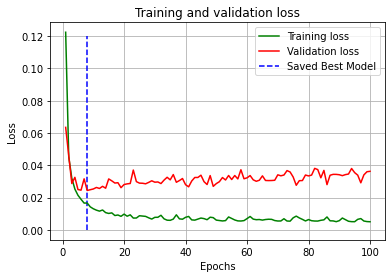

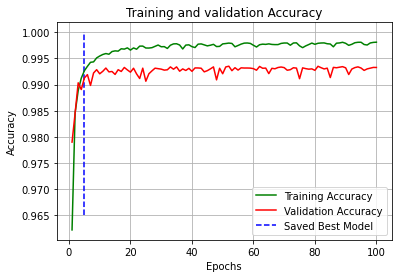

In [29]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.vlines(8, 0, 0.12, colors = 'b', linestyles = 'dashed', label='Saved Best Model') # We can see from the training history above that
                                                      # best model was saved at epoch 5
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='-')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.vlines(5, 0.965, 1, colors = 'b', linestyles = 'dashed', label='Saved Best Model') # We can see from the training history above that
                                                      # best model was saved at epoch 5
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(linestyle='-')
plt.show()    

In [ ]:
tf.keras.backend.clear_session()
del model
del model2 
del imported_model

In [ ]:
tf.keras.backend.clear_session()
del imported_model